### Write the python wrapper classes

In [ ]:
from ctypes import *
import numpy as np

In [ ]:
#load lib
libcpu = cdll.LoadLibrary('./sps_fast_utils_cpu.so')

#specify function args and return types 
libcpu.spectrum_generator_cpu_new.restype = c_void_p
    
libcpu.generate_spec_cpu_exp.argtypes  = [c_void_p,c_double,c_double,c_double,c_double,c_double,c_double,c_void_p]
libcpu.generate_spec_cpu_exp.restype = c_void_p

libcpu.generate_spec_cpu_sfr_vec.argtypes  = [c_void_p,c_double,c_double,c_double,c_double,c_double,c_double,c_void_p,c_void_p]
libcpu.generate_spec_cpu_sfr_vec.restype = c_void_p

libcpu.freeme.argtypes = c_void_p,
libcpu.freeme.restype = None

libcpu.free_spec_gen_cpu.argtypes = c_void_p,
libcpu.free_spec_gen_cpu.restype = None


class Spectrum_generator_cpu(object):
    """Cpu only spectrum generator"""
    
    def __init__(self,measurement_file='../input/testspec1.csv',imf='chabrier'):
        """
        Create a new spectrum generator instance.
            -free it later?
        
        """
        # get a spectrum generator class
        self.obj = libcpu.spectrum_generator_cpu_new(measurement_file,imf)
    
    def generate_spec(self,sfr=None,age=1e9,vdisp=150, metall=0.001,sfr_tau=1e8,
                      dust_tau_v=1.0,dust_mu=0.7):
        """Generate spectrum."""
        if sfr is None:
            return self.generate_spec_exp(age,vdisp, metall,sfr_tau,dust_tau_v,dust_mu)
        else:
            return self.generate_spec_sfr(sfr,age,vdisp, metall,sfr_tau,dust_tau_v,dust_mu)
        
    def generate_spec_exp(self,age,vdisp, metall,sfr_tau,dust_tau_v,dust_mu):
        """Generate spectrum."""
        #generate spectrum
        result_size=c_int()
        res_pointer=libcpu.generate_spec_cpu_exp(self.obj,age,vdisp, metall,sfr_tau,dust_tau_v,dust_mu,byref(result_size))
        
        #spectrum as numpy array
        res=np.ctypeslib.as_array(cast(res_pointer,POINTER(c_double)),shape=(result_size.value,))
        
        #unforutnately i have to make a copy of the array to
        #force it to take ownership of the data and get python
        #delete the data when it deletes the array
        res=np.array(res,copy=True)
        
        #free memory
        libcpu.freeme(res_pointer)
        
        return res
    
    def generate_spec_sfr(self,sfr,age,vdisp, metall,sfr_tau,dust_tau_v,dust_mu):
        """Generate spectrum."""
        #generate specrtrum
        result_size=c_int()
        res_pointer=libcpu.generate_spec_cpu_sfr_vec(self.obj,age,vdisp, metall,sfr_tau,dust_tau_v,dust_mu,c_void_p(sfr.ctypes.data),byref(result_size),)
        
        #spectrum as numpy array
        res=np.ctypeslib.as_array(cast(res_pointer,POINTER(c_double)),shape=(result_size.value,))
    
        #unfortunately i have to make a copy of the array to
        #force it to take ownership of the data and get python
        #delete the data when it deletes the array
        res=np.array(res,copy=True)
        
        #free memory
        libcpu.freeme(res_pointer)
        
        return res
    
    def __del__(self):
        """Free the memory of the spectrum generator class."""
        libcpu.free_spec_gen_cpu(self.obj)

In [1]:
#load lib
lib = cdll.LoadLibrary('./sps_fast_utils.so')

#specify function args and return types 
lib.spectrum_generator_new.restype = c_void_p
        
lib.generate_spec_exp.argtypes  = [c_void_p,c_double,c_double,c_double,c_double,c_double,c_double,c_void_p]
lib.generate_spec_exp.restype = c_void_p

lib.generate_spec_sfr_vec.argtypes  = [c_void_p,c_double,c_double,c_double,c_double,c_double,c_double,c_void_p,c_void_p]
lib.generate_spec_sfr_vec.restype = c_void_p
    
lib.freeme.argtypes = c_void_p,
lib.freeme.restype = None

lib.free_spec_gen.argtypes = c_void_p,
lib.free_spec_gen.restype = None


class Spectrum_generator(object):
    """Opencl spectrum generator"""
    
    def __init__(self,measurement_file='../input/testspec1.csv',imf='chabrier',
                platform=0,device=0):
        """
        Create a new spectrum generator instance.
            -free it later?
        
        """
        # get a spectrum generator class
        self.obj = lib.spectrum_generator_new(measurement_file,imf,platform,device)
        
    def generate_spec(self,sfr=None,age=1e9,vdisp=150, metall=0.001,sfr_tau=1e8,
                      dust_tau_v=1.0,dust_mu=0.7):
        """Generate spectrum."""
        if sfr is None:
            return self.generate_spec_exp(age,vdisp, metall,sfr_tau,dust_tau_v,dust_mu)
        else:
            return self.generate_spec_sfr(sfr,age,vdisp, metall,sfr_tau,dust_tau_v,dust_mu)
        
    def generate_spec_exp(self,age,vdisp, metall,sfr_tau,dust_tau_v,dust_mu):
        """Generate spectrum."""
        #generate specrtrum
        result_size=c_int()
        res_pointer=lib.generate_spec_exp(self.obj,age,vdisp, metall,sfr_tau,dust_tau_v,dust_mu,byref(result_size))
        
        #spectrum as numpy array
        res=np.ctypeslib.as_array(cast(res_pointer,POINTER(c_double)),shape=(result_size.value,))
    
        #unfortunately i have to make a copy of the array to
        #force it to take ownership of the data and get python
        #delete the data when it deletes the array
        res=np.array(res,copy=True)
        
        #free memory
        lib.freeme(res_pointer)
        
        return res
        
    def generate_spec_sfr(self,sfr,age,vdisp, metall,sfr_tau,dust_tau_v,dust_mu):
        """Generate spectrum."""
        #generate specrtrum
        result_size=c_int()
        res_pointer=lib.generate_spec_sfr_vec(self.obj,age,vdisp, metall,sfr_tau,dust_tau_v,dust_mu,c_void_p(sfr.ctypes.data),byref(result_size),)
        
        #spectrum as numpy array
        res=np.ctypeslib.as_array(cast(res_pointer,POINTER(c_double)),shape=(result_size.value,))
    
        #unfortunately i have to make a copy of the array to
        #force it to take ownership of the data and get python
        #delete the data when it deletes the array
        res=np.array(res,copy=True)
    
        #free memory
        lib.freeme(res_pointer)
        
        return res
    def __del__(self):
        """Free the memory of the spectrum generator class."""
        lib.free_spec_gen(self.obj)

# Test it

In [2]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

### Opencl with exponential star formation

In [3]:
#create instance
my_spec_gen=Spectrum_generator(measurement_file='../input/testspec1.csv',imf='chabrier',platform=0,device=0)

#generate a spectrum
start=time.time()
res=my_spec_gen.generate_spec(age=1e9,vdisp=150, metall=0.001,sfr_tau=1e8,dust_tau_v=1.0,dust_mu=0.7)
print time.time()-start

0.0042519569397


### Cpu only with exponential star formation

In [4]:
#create instance
my_spec_gen_cpu=Spectrum_generator_cpu(measurement_file='../input/testspec1.csv',imf='chabrier')

#generate a spectrum
start=time.time()
res_cpu=my_spec_gen_cpu.generate_spec(age=1e9,vdisp=150, metall=0.001,sfr_tau=1e8,dust_tau_v=1.0,dust_mu=0.7)
print time.time()-start

0.0240659713745


max diff: 2.5389460959e-10


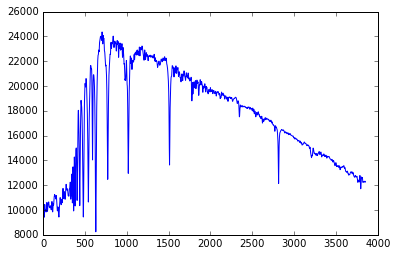

In [5]:
print 'max diff:',np.max((res-res_cpu)**2/(res*res_cpu))
plt.plot(res_cpu)

### Opencl  with user defined start formation

In [6]:
#generate a spectrum
start=time.time()
res=my_spec_gen.generate_spec(age=1e9,vdisp=150, metall=0.001,sfr_tau=1e8,dust_tau_v=1.0,dust_mu=0.7,
                                     sfr=np.ones(221))
print time.time()-start

0.0182549953461


### Cpu only with user defined start formation

In [7]:
#generate a spectrum
start=time.time()
res_cpu=my_spec_gen_cpu.generate_spec(age=1e9,vdisp=150, metall=0.001,sfr_tau=1e8,dust_tau_v=1.0,dust_mu=0.7,
                                     sfr=np.ones(221))
print time.time()-start

0.0186288356781


max diff: 2.4636831497e-10


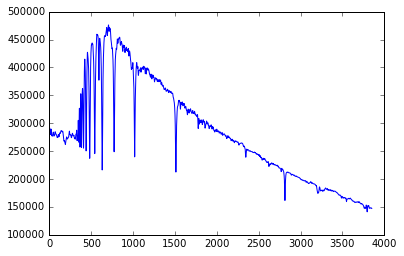

In [8]:
print 'max diff:',np.max((res-res_cpu)**2/(res*res_cpu))
plt.plot(res)

### Test

In [9]:
specs=[]
for i in xrange(1000):
    specs.append(my_spec_gen.generate_spec())